# Extracting contour lines <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2b_ard_granule](http://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)

## Background
[Contour extraction](https://en.wikipedia.org/wiki/Contour_line) is a fundamental image processing method used to detect and extract the boundaries of spatial features. 
While contour extraction has traditionally been used to precisely map lines of given elevation from digital elevation models (DEMs), contours can also be extracted from any other array-based data source. 
This can be used to support remote sensing applications where the position of a precise boundary needs to be mapped consistently over time, such as extracting dynamic waterline boundaries from satellite-derived remote sensing water index data (e.g. NDWI, MNDWI).

## Description
This notebook demonstrates how to use the `subpixel_contours` function based on tools from `skimage.measure.find_contours` to:

1. Extract one or multiple contour lines from a single two-dimensional digital elevation model (DEM) and export these as a shapefile
2. Optionally include custom attributes in the extracted contour features
3. Load in a multi-dimensional satellite dataset from Digital Earth Australia, and extract a single contour value consistently through time along a specified dimension
4. Filter the resulting contours to remove small noisy features

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [5]:
import sys
import datacube
import rioxarray
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from affine import Affine
from datacube.utils.geometry import CRS

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours


### Connect to the datacube

In [6]:
dc = datacube.Datacube(app='Contour_extraction')


## Load elevation data
To demonstrate contour extraction, we first need to obtain an elevation dataset. 
Here we load a 250 m resolution [Digital Elevation Model raster from the Shuttle Radar Topography Mission for the Canberra region (Jarvis et al. 2008)](https://cgiarcsi.community/data/srtm-90m-digital-elevation-database-v4-1/) using the `rioxarray.open_rasterio` function.

In [7]:
# Read in the elevation data from file
raster_path = '../Supplementary_data/Reprojecting_data/canberra_dem_250m.tif'
elevation_array = rioxarray.open_rasterio(raster_path).squeeze('band')

# Print the data
elevation_array

<xarray.DataArray (y: 90, x: 95)>
[8550 values with dtype=int16]
Coordinates:
    band         int64 1
  * x            (x) float64 149.0 149.0 149.0 149.0 ... 149.2 149.2 149.2 149.2
  * y            (y) float64 -35.2 -35.2 -35.2 -35.21 ... -35.38 -35.38 -35.38
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

We can plot the elevation data using a custom terrain-coloured colour map:

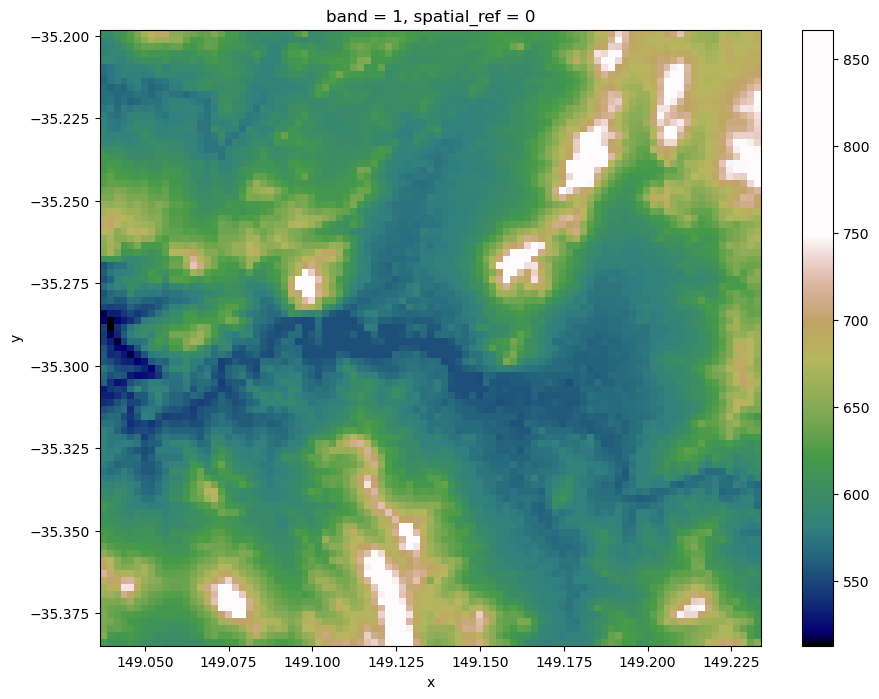

In [8]:
# Create a custom colourmap for the DEM
colors_terrain = plt.cm.gist_earth(np.linspace(0.0, 1.5, 100))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('terrain', 
                                                            colors_terrain)

# Plot elevation data
elevation_array.plot(size=8, cmap=cmap_terrain)


## Contour extraction in 'single array, multiple z-values' mode
The `dea_spatialtools.subpixel_contours` function uses `skimage.measure.find_contours` to extract contour lines from an array. 
This can be an elevation dataset like the data imported above, or any other two-dimensional or multi-dimensional array. 
We can extract contours from the elevation array imported above by providing a single z-value (e.g. elevation) or a list of z-values. 

### Extracting a single contour
Here, we extract a single 600 m elevation contour:

In [9]:
# Extract contours
contours_gdf = subpixel_contours(da=elevation_array,
                                 z_values=600)

# Print output
contours_gdf

Operating in multiple z-value, single array mode


,z_value,geometry
0,600,"MULTILINESTRING ((149.08043 -35.19917, 149.080..."


This returns a `geopandas.GeoDataFrame` containing a single contour line feature with the z-value (i.e. elevation) given in a shapefile field named `z_value`. 
We can plot contour this for the Canberra subset:

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

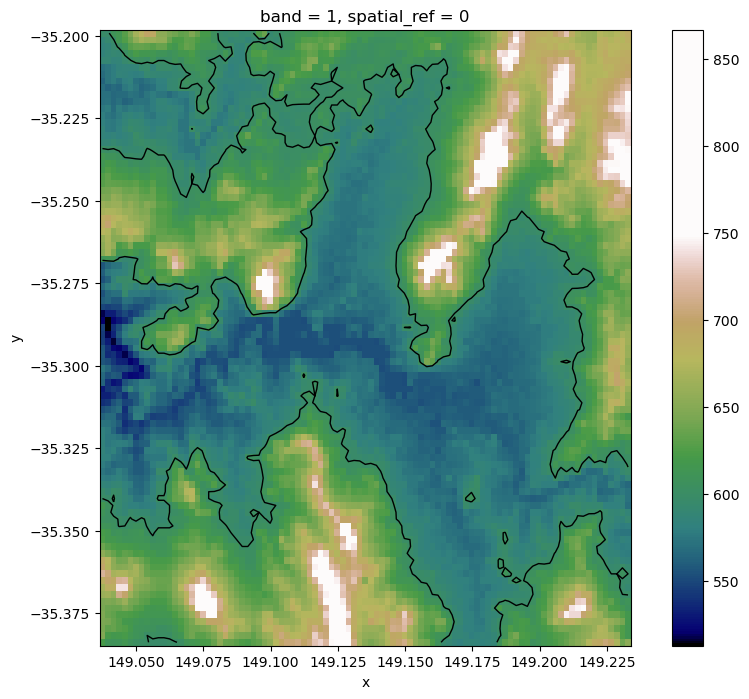

In [10]:
elevation_array.plot(size=8, cmap=cmap_terrain)
contours_gdf.plot(ax=plt.gca(), linewidth=1.0, color='black')  


### Extracting multiple contours 
We can easily import multiple contours from a single array by supplying a list of z-values to extract. 
The function will then extract a contour for each value in `z_values`, skipping any contour elevation that is not found in the array.


Operating in multiple z-value, single array mode
Failed to generate contours: 500


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

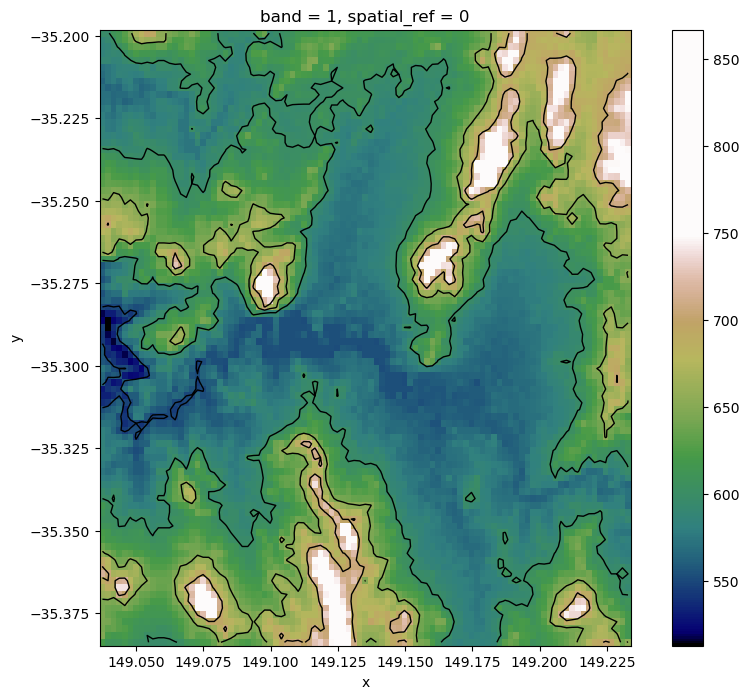

In [11]:
# List of elevations to extract
z_values = [500, 550, 600, 650, 700]

# Extract contours
contours_gdf = subpixel_contours(da=elevation_array,
                                 z_values=z_values)

# Plot extracted contours over the DEM
elevation_array.plot(size=8, cmap=cmap_terrain)
contours_gdf.plot(ax=plt.gca(), linewidth=1.0, color='black')  

### Custom shapefile attributes
By default, the shapefile includes a single `z_value` attribute field with one feature per input value in `z_values`. 
We can instead pass custom attributes to the output shapefile using the `attribute_df` parameter. 
For example, we might want a custom column called `elev_cm` with heights in cm instead of m, and a `location` column giving the location (Australian Capital Territory or ACT). 

We can achieve this by first creating a `pandas.DataFrame` with column names giving the name of the attribute we want included with our contour features, and one row of values for each number in `z_values`:

In [12]:
# Elevation values to extract
z_values = [550, 600, 650]

# Set up attribute dataframe (one row per elevation value above)
attribute_df = pd.DataFrame({'elev_cm': [55000, 60000, 65000],
                             'location': ['ACT', 'ACT', 'ACT']})

# Print output
attribute_df.head()

,elev_cm,location
0,55000,ACT
1,60000,ACT
2,65000,ACT


We can now extract contours, and the resulting contour features will include the attributes we created above:

In [13]:
# Extract contours with custom attribute fields:
contours_gdf = subpixel_contours(da=elevation_array,                               
                                 z_values=z_values,
                                 attribute_df=attribute_df)

# Print output
contours_gdf.head()

Operating in multiple z-value, single array mode


,z_value,elev_cm,location,geometry
0,550,55000,ACT,"MULTILINESTRING ((149.03757 -35.31275, 149.039..."
1,600,60000,ACT,"MULTILINESTRING ((149.08043 -35.19917, 149.080..."
2,650,65000,ACT,"MULTILINESTRING ((149.06117 -35.19917, 149.061..."


### Exporting contours to file
To export the resulting contours to file, use the `output_path` parameter. 
The function supports two output file formats:

1. GeoJSON (.geojson)
2. Shapefile (.shp)


In [14]:
subpixel_contours(da=elevation_array,                               
                  z_values=z_values,
                  output_path='output_contours.geojson')

Operating in multiple z-value, single array mode
Writing contours to output_contours.geojson


,z_value,geometry
0,550,"MULTILINESTRING ((149.03757 -35.31275, 149.039..."
1,600,"MULTILINESTRING ((149.08043 -35.19917, 149.080..."
2,650,"MULTILINESTRING ((149.06117 -35.19917, 149.061..."


## Contours from non-elevation datasets in in 'single z-value, multiple arrays' mode
As well as extracting multiple contours from a single two-dimensional array, `subpixel_contours` also allows you to extract a single z-value from every array along a specified dimension in a multi-dimensional array. 
This can be useful for comparing the changes in the landscape across time. 
The input multi-dimensional array does not need to be elevation data: contours can be extracted from any type of data. 

For example, we can use the function to extract the boundary between land and water (for a more in-depth analysis using contour extraction to monitor coastal erosion, [see this notebook](../Real_world_examples/Coastal_erosion.ipynb)). 
First, we will load in a time series of Sentinel-2 imagery and calculate a simple Modified Normalized Difference Water Index (MNDWI) on two images. 
This index will have high values where a pixel is likely to be open water (e.g. MNDWI > 0, coloured in blue below):

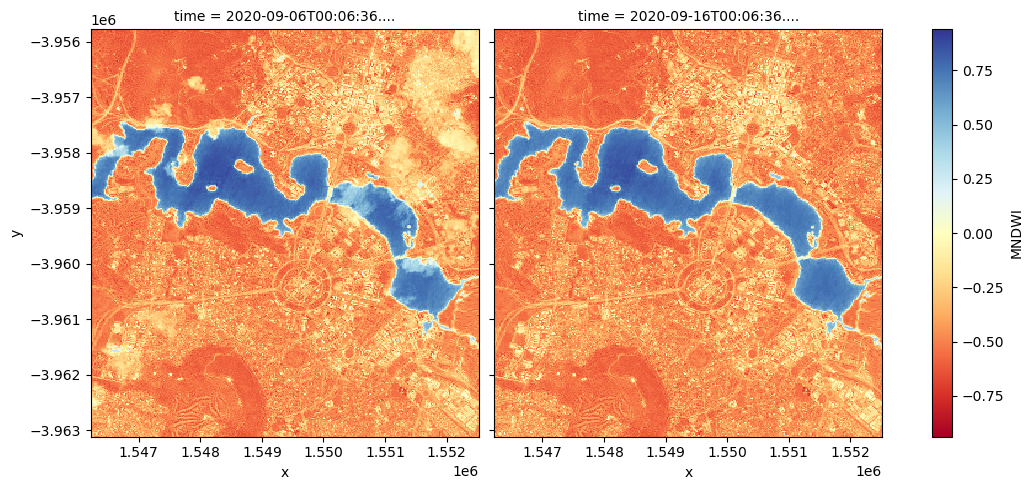

In [15]:
# Set up a datacube query to load data for
query = {'lat': (-35.27, -35.33),
         'lon': (149.09, 149.15),
         'time': ('2020-09-06', '2020-09-16'),
         'measurements': ['nbart_green', 'nbart_swir_2'],
         'output_crs': 'EPSG:3577',
         'resolution': (-20, 20)}

# Load Sentinel 2 data
s2_ds = dc.load(product='ga_s2am_ard_3', 
                group_by='solar_day', 
                **query)

# Calculate NDWI on the first and last image in the dataset
s2_ds = calculate_indices(s2_ds,
                          index='MNDWI',
                          collection='ga_s2_3')

# Plot the two images side by size
s2_ds.MNDWI.plot(col='time', cmap='RdYlBu', size=5)


We can now identify the land-water boundary by extracting the 0 MNDWI contour for each array in the dataset along the `time` dimension. 
By plotting the resulting contour lines for a zoomed in area, we can then start to compare phenomenon like lake levels across time.


Operating in single z-value, multiple arrays mode


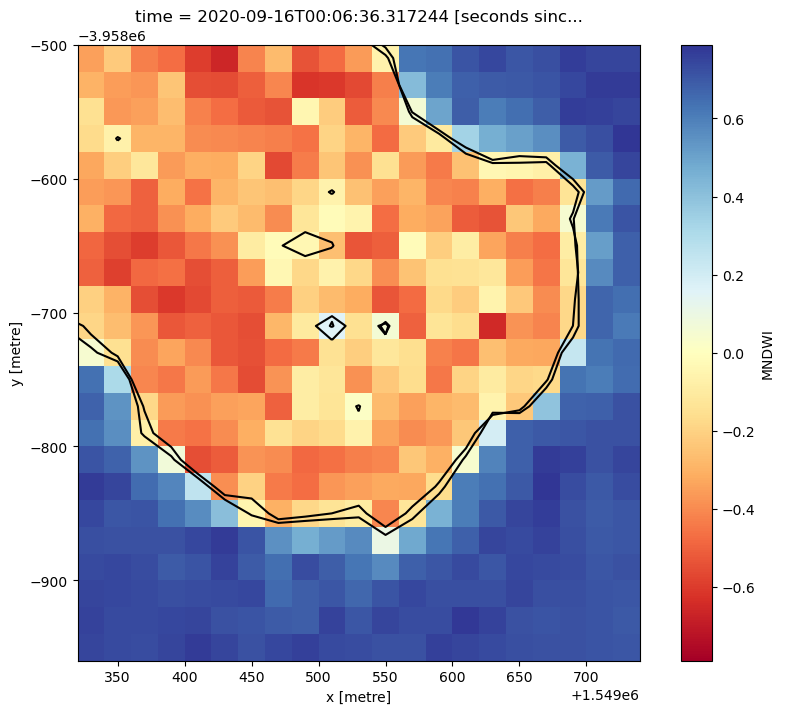

In [16]:
# Extract the 0 MNDWI contour from both timesteps in the MNDWI data
contours_s2_gdf = subpixel_contours(da=s2_ds.MNDWI, z_values=0, dim='time')

# Plot contours over the top of array
s2_ds.MNDWI.sel(time='2020-09-16',
                x=slice(1549320, 1549733),
                y=slice(-3958494, -3958963)).plot(size=8, cmap='RdYlBu')
contours_s2_gdf.plot(ax=plt.gca(), linewidth=1.5, color='black');

### Dropping small contours
Contours produced by `subpixel_contours` can include many small features. 
We can optionally choose to extract only contours larger than a certain number of vertices using the `min_vertices` parameter. 
This can be useful for focusing on large contours, and remove possible noise in a dataset. Here we set `min_vertices=10` to keep only contours with at least 10 vertices. 
Observe the tiny waterbodies in the middle of the image disappear:

Operating in single z-value, multiple arrays mode


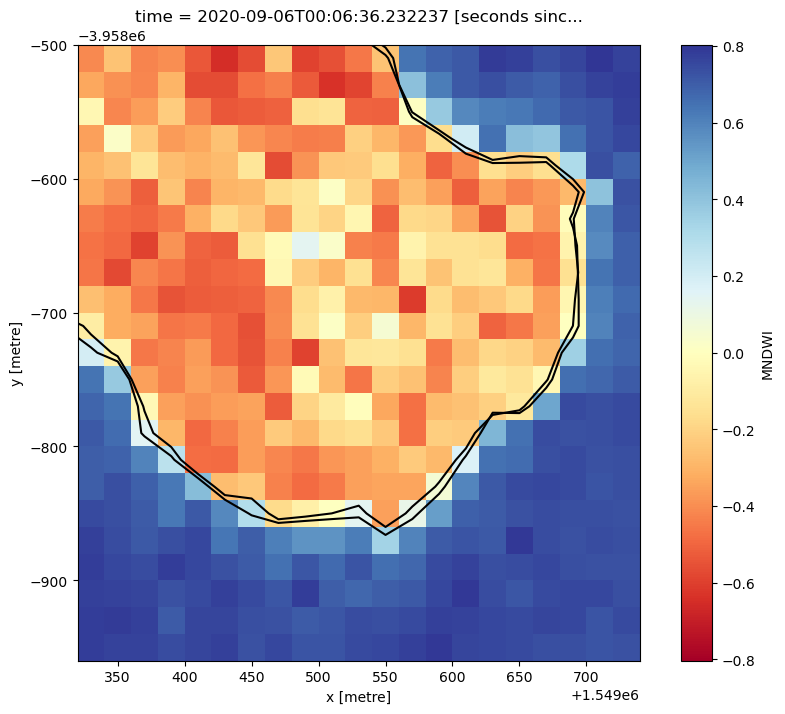

In [17]:
# Extract the 0 NDWI contour from both timesteps in the MNDWI data
contours_s2_gdf = subpixel_contours(da=s2_ds.MNDWI, z_values=0, min_vertices=10)

# Plot contours over the top of array
s2_ds.MNDWI.sel(time='2020-09-06',
                x=slice(1549320, 1549733),
                y=slice(-3958494, -3958963)).plot(size=8, cmap='RdYlBu')
contours_s2_gdf.plot(ax=plt.gca(), linewidth=1.5, color='black');

### Exporting vector contours
To export our output contour data as a vector file (e.g. ESRI Shapefile or GeoJSON), just provide an `output_path`.

Here we export our data as a GeoJSON file called `output.geojson`:

In [18]:
subpixel_contours(da=s2_ds.MNDWI,
                  z_values=0,
                  dim='time',
                  output_path='output.geojson')

Operating in single z-value, multiple arrays mode
Writing contours to output.geojson


,time,geometry
0,2020-09-06,"MULTILINESTRING ((1549452.587 -3955790.000, 15..."
1,2020-09-16,"MULTILINESTRING ((1549451.796 -3955790.000, 15..."


***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2023

**Compatible datacube version:** 

In [19]:
print(datacube.__version__)

1.8.13


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex/) -->